# Analysis based on Regression Trees

> Using Decision Trees and Random Forests

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from fastai.tabular.all import add_datepart, Categorify, FillMissing, Normalize,cont_cat_split, TabularPandas, tabular_learner, F
import joblib
from sklearn.tree import export_graphviz
import graphviz
import re
import dtreeviz
import math
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc
import scipy
import warnings
warnings.simplefilter('ignore', FutureWarning)
import matplotlib.pyplot as plt
import holidays

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

## Definitions

In [ ]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

path = Path('data/datasets/autos.csv')

target_variable = 'sale_duration'
outliers = dict (numeric_variables_high=0.99,
                 numeric_variables_low=0.01,
                 date_created=True)
add_datepart_flag = True

## Load data

In [ ]:
cd ..

/home/jaumeamllo/workspace/mine/tabularml


In [ ]:
df = pd.read_csv(path, encoding="ISO-8859-1", parse_dates=['dateCrawled', 'dateCreated', 'lastSeen'])

In [ ]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:21


## Cleaning and EDA

### Outliers

In [ ]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


- We see outliers in:

1. Price: minimum value 0, and maximum value > 2000M euros
1. Year of registration: minimum value 1000, and maximum value > 3000
1. Month of registration: minimum value 0
1. powerPS: minimum value 0, maximum value 20K

- We also see that nrOfPictures is always zero, so that it is not relevant

We have two possibilities:
    
1. Remove rows with outliers
2. Treat outlier values as missing values

Outlier detection methods:
    
1. Based on percentile
1. Based on z-score

In [ ]:
numerical_variables = [
    x for x in df.dtypes.index 
    if (str(df.dtypes[x]).startswith ('int') or str(df.dtypes[x]).startswith ('float')) and x != 'postalCode'
]
numerical_variables

['price',
 'yearOfRegistration',
 'powerPS',
 'kilometer',
 'monthOfRegistration',
 'nrOfPictures']

In [ ]:
categorical_variables = set (df.columns).difference (numerical_variables)
categorical_variables

{'abtest',
 'brand',
 'dateCrawled',
 'dateCreated',
 'fuelType',
 'gearbox',
 'lastSeen',
 'model',
 'name',
 'notRepairedDamage',
 'offerType',
 'postalCode',
 'seller',
 'vehicleType'}

In [ ]:
categorical_variables = categorical_variables.difference ({'dateCrawled', 'dateCreated', 'name', 'lastSeen'})
categorical_variables = list (categorical_variables)

In [ ]:
df_clean = df.copy()
df_clean[numerical_variables] = df_clean[numerical_variables].apply (
    lambda x: x.mask ((x < x.quantile(outliers['numeric_variables_low'])) | (x > x.quantile(outliers['numeric_variables_high'])))
)

# see if there are rows that have all values missing and need to be removed, and
# check maximum ratio of missing values in one row
df_clean[numerical_variables].isna().all(axis=1).any(), df_clean[numerical_variables].isna().mean(axis=1).max()

(False, 0.5)

### Remove nrOfPictures

In [ ]:
df_clean = df_clean.drop (columns='nrOfPictures')
numerical_variables.remove ('nrOfPictures')

### dateCreated

In [ ]:
df_clean.dateCreated.max()-df_clean.dateCreated.min()

Timedelta('759 days 00:00:00')

The time span is more than 2 years. However, we see below that there are only few cases where the ad was posted more than few months ago, while the rest are just a few months old. To see that, we transform `dateCreated` to the offset in terms of number of months since the earliest ad in the dataset:

In [ ]:
df_clean['offset_date'] = (df_clean['dateCreated']-df_clean['dateCreated'].min()).dt.days

<Axes: >

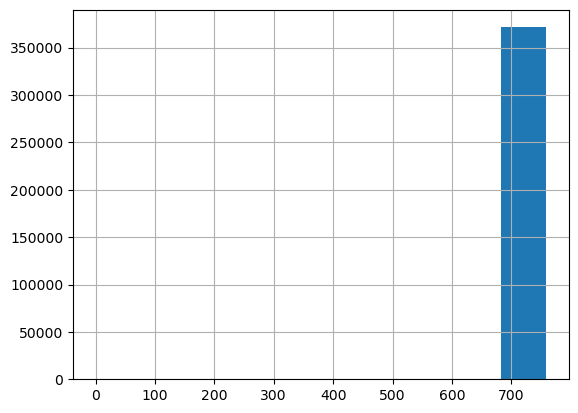

In [ ]:
df_clean.offset_date.hist()

Clearly, almost all the ads are in one bin. Let's look at this:

In [ ]:
number_ads, bins = np.histogram (df_clean.offset_date)
pd.DataFrame ([number_ads, bins[1:]], index=['number_ads','bins'])

,0,1,2,3,4,5,6,7,8,9
number_ads,1.0,0.0,0.0,0.0,1.0,0.0,4.0,5.0,53.0,371464.0
bins,75.9,151.8,227.7,303.6,379.5,455.4,531.3,607.2,683.1,759.0


In the table above, we see that the last bin is where almost all the ads are, followed by the second to last bin, with few ads. From the 5th bin downwards, there are only 2 ads.

In [ ]:
very_old_ads = df_clean[df_clean.offset_date < 450]
other_ads = df_clean[df_clean.offset_date >= 450]

print ('oldest ads created between: ', very_old_ads.dateCreated.min(),very_old_ads.dateCreated.max())

print ('remaining ads created between: ', other_ads.dateCreated.min(),other_ads.dateCreated.max())

oldest ads created between:  2014-03-10 00:00:00 2015-03-20 00:00:00
remaining ads created between:  2015-06-11 00:00:00 2016-04-07 00:00:00


We have four options: 

    - no outlier
    - oldest (2014) is outlier
    - two oldest (before mid year 2016) are outliers.
    - all but the ones in the last two bins (with 53 and 371464 rows) are outliers 

In [ ]:
if outliers['date_created']:
    df_clean = df_clean[df_clean.dateCreated >= '2015-06-01']

In [ ]:
df_clean = df_clean.drop (columns = 'offset_date')

### yearRegistration + monthRegistration

We use `yearOfRegistration` and `monthOfRegistration` to calculate the age of the vehicle, in number of months since the ad was posted. We first look if the outlier removal removed suspicious low and high values:

In [ ]:
df_clean[['monthOfRegistration','yearOfRegistration']].describe().loc[['min','max']]

,monthOfRegistration,yearOfRegistration
min,0.0,1978.0
max,12.0,2018.0


There are still months with value 0, we treat them as missing values. We impute them using the middle of the year, month 6.

In [ ]:
df_clean.loc [df_clean.monthOfRegistration==0, 'monthOfRegistration'] = 6

In [ ]:
df_clean['age'] = pd.to_datetime(df_clean.dateCreated.max()) - pd.to_datetime ({
    'month': df_clean.monthOfRegistration,
    'year': df_clean.yearOfRegistration,
    'day': np.tile (15, df_clean.shape[0])}
)

df_clean['age'] = df_clean['age'].dt.days

In [ ]:
numerical_variables.remove ('yearOfRegistration')
numerical_variables.remove ('monthOfRegistration')
numerical_variables.append ('age')

### Target variable

In [ ]:
df_clean ['lastSeen'].isna().any(), df_clean ['dateCreated'].isna().any()

(False, False)

In [ ]:
df_clean[target_variable] = (df_clean ['lastSeen'] - df_clean['dateCreated']).dt.days

### date information

Depending on whether the ad was posted on a weekend, on a month where there is holidays, etc., more people might be able to look at it and it might be sold more quickly. We add this information here:

In [ ]:
if add_datepart_flag:
    country_holidays = holidays.country_holidays('DE')
    df_clean['holidays'] = [int(day in country_holidays) for day in df_clean.dateCreated]
    df_clean['day_of_week'] = df_clean.dateCreated.dt.dayofweek.values

In [ ]:
numerical_variables.append ('day_of_week')
categorical_variables.append ('holidays')

### Histograms 

In [ ]:
numerical_variables

['price', 'powerPS', 'kilometer', 'age', 'day_of_week']

<Axes: >

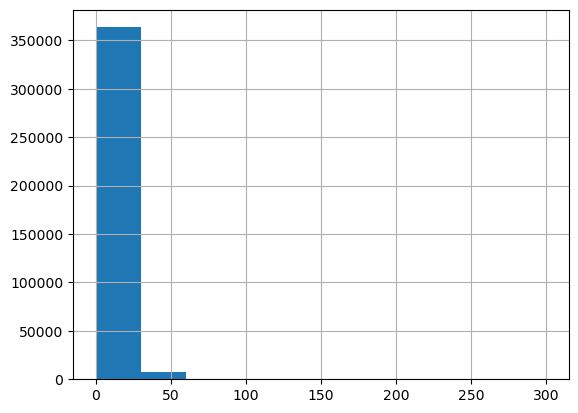

In [ ]:
df_clean.sale_duration.hist()

<Axes: >

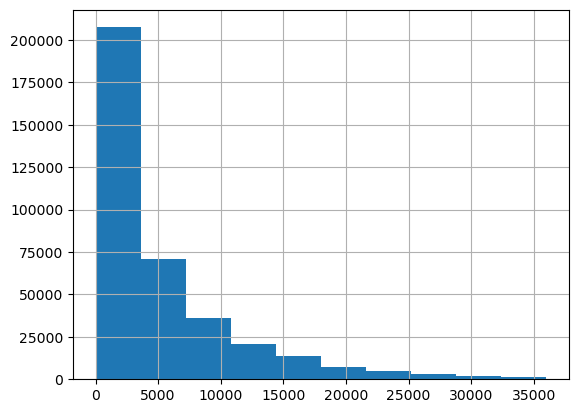

In [ ]:
df_clean['price'].hist()

<Axes: >

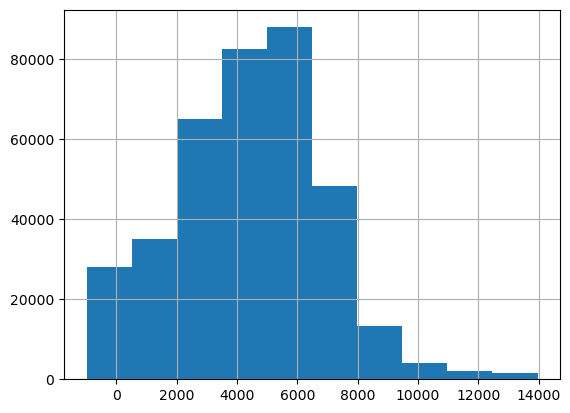

In [ ]:
df_clean['age'].hist()

<Axes: >

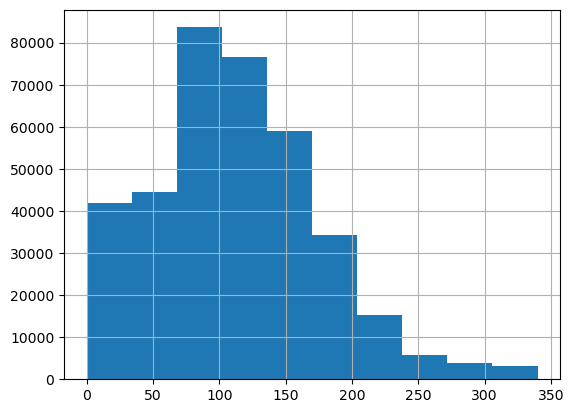

In [ ]:
df_clean['powerPS'].hist()

<Axes: >

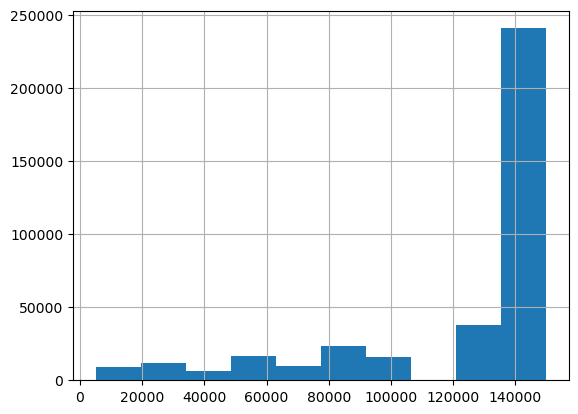

In [ ]:
df_clean['kilometer'].hist()

## Split data and preprocess

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
#X = df_clean[numerical_variables+categorical_variables]
#X = X.drop (columns = target_variable)
#y = df_clean[target_variable]

In [ ]:
train_idx, valid_idx = train_test_split(np.arange(df_clean.shape[0]), test_size=0.30, random_state=42)

In [ ]:
# Using `Categorify`, we replace columns in `categorical_variables` list with numeric categorical columns.
# We use just an discrete value instead of using a one-hot encoding. This tends to work
# better for decision trees and random forests, as explored in "Splitting on Categorical Predictors in Random Forests" 
#
# Using `FillMissing`, we replace missing values with the median, 
# and we create a boolean column that is True for any row where the value was missing
procs = [Categorify, FillMissing]
tabular = TabularPandas (df_clean, procs, categorical_variables, numerical_variables, y_names=target_variable, splits=(list(train_idx),list(valid_idx)))

In [ ]:
path = Path('data/datasets')
joblib.dump (tabular, path / 'tabular.pkl')

['data/datasets/tabular.pkl']

## Decision Tree

We start by fitting a very simple yet powerful type of model, the decision tree. A good characteristic of this type of model is that it is interpretable and allows to analyze the data and the important variables.

In [ ]:
tabular = joblib.load (path / 'tabular.pkl')

In [ ]:
X, y = tabular.train.xs, tabular.train.y
valid_X, valid_y = tabular.valid.xs, tabular.valid.y

### Visualization

We can visualize on which basis the tree splits the data. We see that:

    - The most important predictor is the `price`: the lower the price, the lower the duration of the sale. 
    - The data where most errors happen is the one for large durations. This might be due to the few cases with a long duration, which could be considered almost outliers.

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit (X, y);

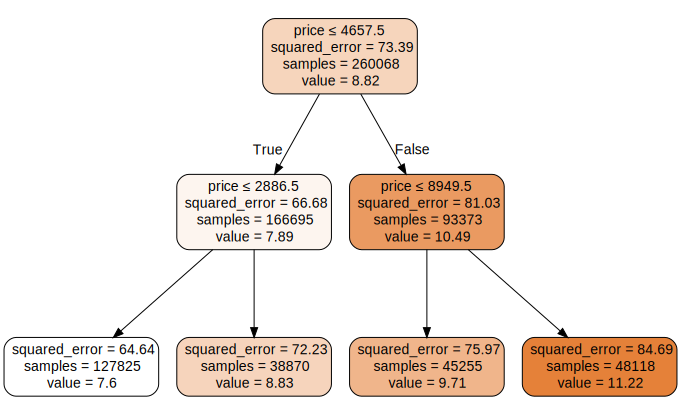

In [ ]:
draw_tree(m, X, size=10, leaves_parallel=True, precision=2)

We can visualize the same using the `dtreeviz` library:

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
viz = dtreeviz.model (m, X.iloc[samp_idx], y.iloc[samp_idx], feature_names=X.columns, target_name=target_variable)

/home/jaumeamllo/miniconda3/envs/tsforecast/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


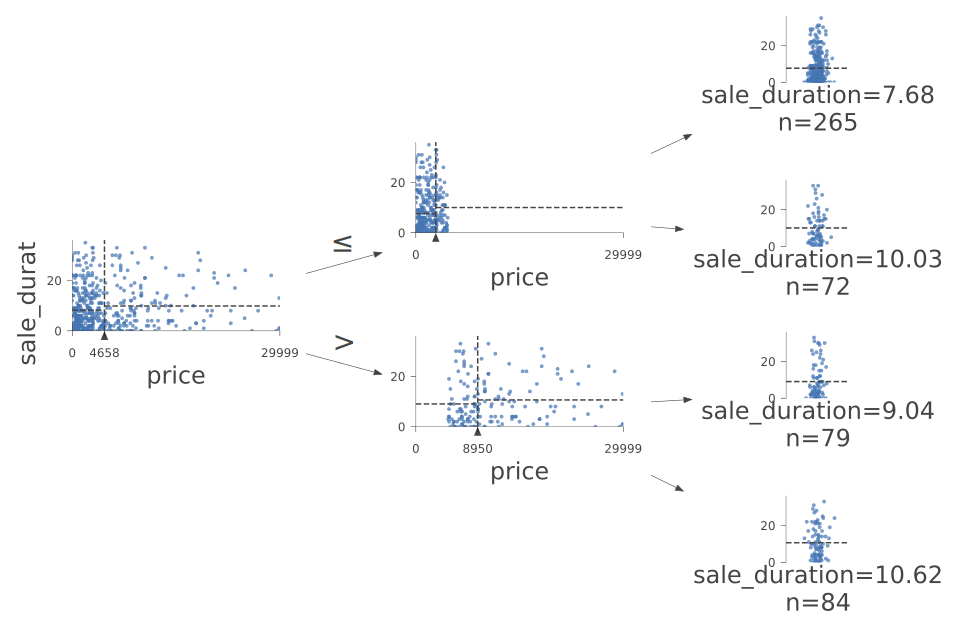

In [ ]:
viz.view (fontname='DejaVu Sans', scale=2, label_fontsize=16,
        orientation='LR')

### Training

Let's first start by training a full size decision tree.

In [ ]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X, y);

### Evaluation

We use the root of the mean squared error as evaluation metric.

In [ ]:
def r_mse (pred, y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse (dt_model, X, y): 
    return r_mse(dt_model.predict(X), y)

Let's see at the error on the training set:

In [ ]:
m_rmse (dt_model, X, y)

0.283855

... and on the validation set:

In [ ]:
m_rmse (dt_model, valid_X, valid_y)

11.638111

We can see that we are clearly overfitting. Let's look at the number of leaves, and compare it against the total number of observations:

In [ ]:
dt_model.get_n_leaves(), len(X)

(201459, 260068)

The number of leaves is similar to the number of observations. We need to reduce the size of the decision tree:

In [ ]:
dt_model = DecisionTreeRegressor (min_samples_leaf=25)
dt_model.fit (tabular.train.xs, tabular.train.y)
m_rmse (dt_model, X, y), m_rmse(dt_model, valid_X, valid_y)

(7.683235, 8.817769)

We get a much better error on validation set, let's see the number of leaves:

In [ ]:
dt_model.get_n_leaves()

7949

## Random Forest

We have built a baseline using Decision Trees. Let us explore now the use of Random Rorests

### Training

In [ ]:
def fitted_rf (X, y, n_estimators=128, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor (
        n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True, **kwargs
    ).fit(X, y)

In [ ]:
rf_model = fitted_rf (X, y);

### Evaluation

In [ ]:
m_rmse (rf_model, X, y), m_rmse(rf_model, valid_X, valid_y), r_mse (rf_model.oob_prediction_, y)

(6.046889, 8.268613, 8.212559)

We see whether using another rule for max_features makes the model improve:

In [ ]:
rf_model_2 = fitted_rf (X, y, max_features='sqrt');
m_rmse (rf_model_2, X, y), m_rmse(rf_model_2, valid_X, valid_y), r_mse(rf_model_2.oob_prediction_, y)

(6.649198, 8.299971, 8.23266)

We see that the Random Forest achieves slightly better results. Usually, the more estimators the better the accuracy, although at the expense of higher computational cost.

### Visualization

Let's see the impact of n_estimators on the performance:

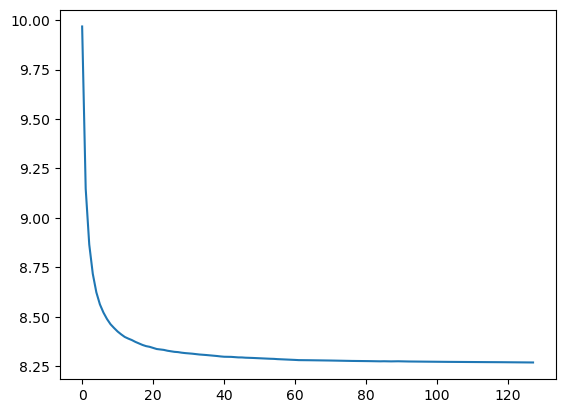

In [ ]:
import warnings
warnings.filterwarnings ('ignore')
preds = np.stack([t.predict(valid_X) for t in rf_model.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(128)]);

We see that the accuracy plateaus from 80 estimators onwards

### Interpretation 

#### Confidence

We look at the standard deviation of the predictions across the different trees. For those sales where there is low standard deviation, most of the trees agree on the sale duration estimate. This is useful in production, to maybe avoid providing a predition for those requests where there is little agreement on the sale duration.

In [ ]:
preds = np.stack([t.predict(valid_X) for t in rf_model.estimators_])
preds_std = preds.std(0)

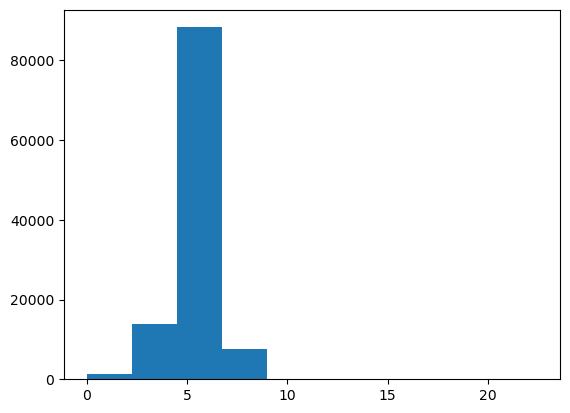

In [ ]:
plt.hist (preds_std);

We see that there is in general high standard deviation for most sales, except for few cases.

#### Feature importance

Let's look at what features are most important for the regression task:

In [ ]:
def rf_feat_importance (rf_model, df):
    return pd.DataFrame({'cols':df.columns, 'imp':rf_model.feature_importances_}).sort_values('imp', ascending=False)

In [ ]:
importance = rf_feat_importance (rf_model, X)
importance

,cols,imp
0,postalCode,0.193267
14,price,0.183306
17,age,0.153722
15,powerPS,0.098682
9,model,0.088152
8,brand,0.061822
18,day_of_week,0.061382
6,vehicleType,0.042122
16,kilometer,0.036371
7,abtest,0.023639


We see that the most important features are: 
    
    - postalCode: probably due to the higher density of population, and thus buyers, in certain areas.
    - price: cheaper cars are sold faster.
    - age: newer is better
    
Surprisingly, the day of the week plays a role even more important than the number of kilometers, to be sold faster, maybe because people look at ads more at certain days of the week.

Let's look at the same graphically:

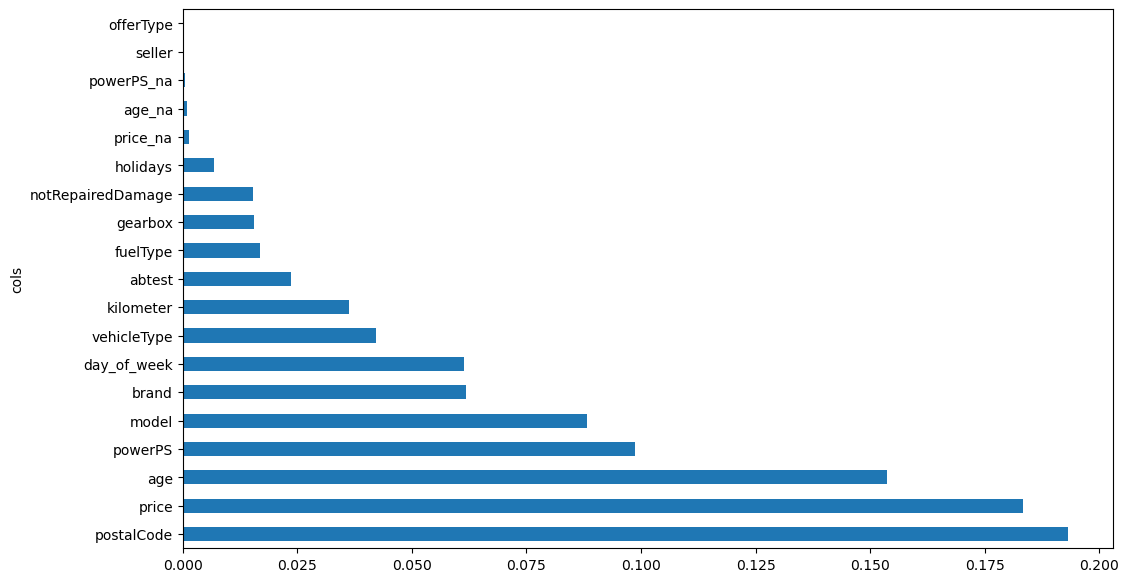

In [ ]:
def plot_feature_importance (importance):
    return importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_feature_importance(importance);

### Removing variables

We see if we can improve the performance by removing those features that have very little importance and might be adding noise:

In [ ]:
def evaluate_removing_variables (importance, X, y, valid_X, valid_y, threhsold):
    to_keep = importance[importance.imp>threhsold].cols
    X_imp = X[to_keep]
    valid_X_imp = valid_X[to_keep]

    rf_model = fitted_rf(X_imp, y)
    print (m_rmse(rf_model, X_imp, y), m_rmse(rf_model, valid_X_imp, valid_y), r_mse (rf_model.oob_prediction_, y))
    return rf_model, X_imp, valid_X_imp, to_keep

In [ ]:
rf_model, X_imp, valid_X_imp, to_keep = evaluate_removing_variables (importance, X, y, valid_X, valid_y, 0.0001)

6.046527 8.272227 8.212275


There is almost no improvement, let's see a bit more agressive pruning:

In [ ]:
rf_model2, X_imp2, valid_X_imp2, to_keep2 = evaluate_removing_variables (importance, X, y, valid_X, valid_y, 0.001)

6.047854 8.270291 8.209731


In [ ]:
rf_model2, X_imp2, valid_X_imp2, to_keep2 = evaluate_removing_variables (importance, X, y, valid_X, valid_y, 0.005)

6.011364 8.271299 8.214086


The best threshold seems to be 0.0001. Let's use it and look at the feature importance again, after removing variables with low importance:

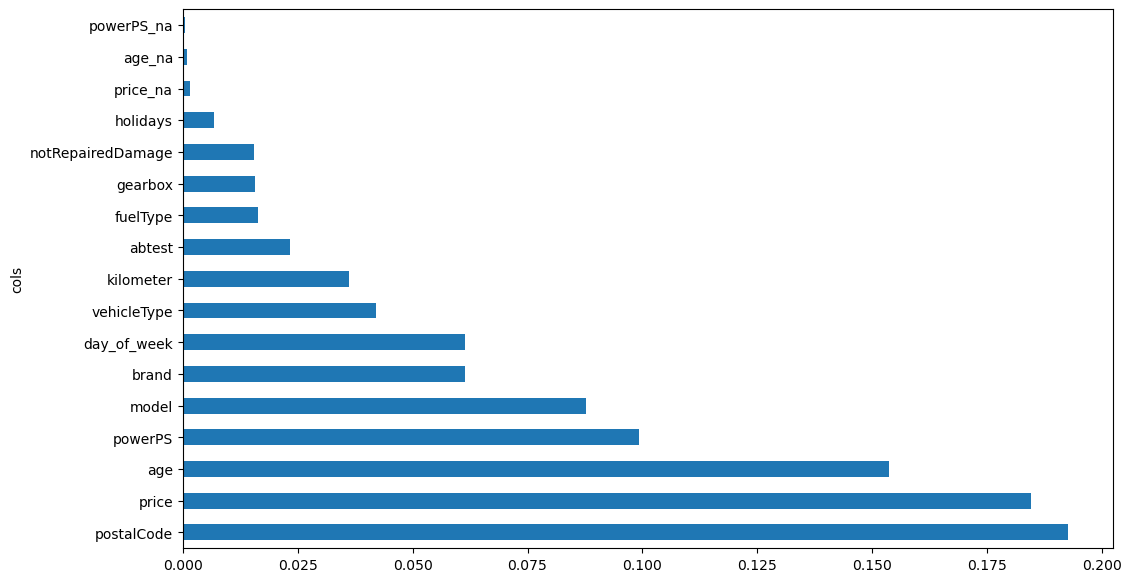

In [ ]:
importance = rf_feat_importance(rf_model, X_imp)
plot_feature_importance(importance);

It seems that,  now, the postalCode is even a better predictor than the price.

### Removing redundant variables

We see if there are variables that might be closely correlated, in terms of ranking:

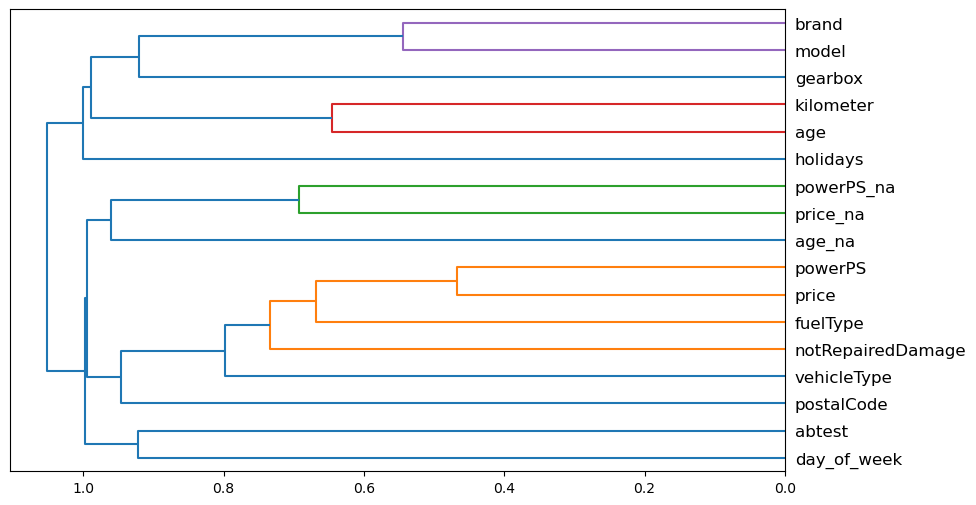

In [ ]:
cluster_columns(X_imp)

PowerPS and price seem to be quite correlated. We see what happens when we remove each of the variables in turn. To do it quickly, we use the out-of-bag score, by using a random forest where each tree is trained on a smaller subset of data, so that the out-of-bag score is measured on the remaining subset. This score indicates the generalization provided, being the higher the better.

In [ ]:
def get_oob (df, y):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Let's see the score of the original features:

In [ ]:
def fitted_rf2 (X, y):
    return RandomForestRegressor (
        n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True).fit(X, y)

In [ ]:
original_oob = get_oob(X_imp, y)
original_oob

0.06004192969502087

In [ ]:
oob_scores = {c:get_oob(X_imp.drop(c, axis=1), y) for c in (importance.cols)}
oob_scores

{'postalCode': 0.059090459721238386,
 'price': 0.041734978050511184,
 'age': 0.052544457139108824,
 'powerPS': 0.05927059749295849,
 'model': 0.05935352481651346,
 'brand': 0.058121169190910815,
 'day_of_week': 0.05897956070963928,
 'vehicleType': 0.05963674075501557,
 'kilometer': 0.05998481083754459,
 'abtest': 0.0609014566350391,
 'fuelType': 0.06018838967536899,
 'gearbox': 0.059770281422265814,
 'notRepairedDamage': 0.060825931355629415,
 'holidays': 0.05685352002306021,
 'price_na': 0.06032227416978375,
 'age_na': 0.060329776168749794,
 'powerPS_na': 0.060278937122809295}

In [ ]:
{k:oob_scores[k] for k in oob_scores if oob_scores[k] > original_oob}

{'abtest': 0.0609014566350391,
 'fuelType': 0.06018838967536899,
 'notRepairedDamage': 0.060825931355629415,
 'price_na': 0.06032227416978375,
 'age_na': 0.060329776168749794,
 'powerPS_na': 0.060278937122809295}

It seems that dropping the notRepairedDamage, abtest, and powerPS_na might be beneficial

In [ ]:
def evaluate_removing_redundant (to_drop, X_imp, y, valid_X, valid_y):
    print ('OOB score: ', get_oob(X_imp.drop(to_drop, axis=1), y))
    X_final = X_imp.drop(to_drop, axis=1)
    valid_X_final = valid_X_imp.drop(to_drop, axis=1)
    rf_model = fitted_rf(X_final, y)
    print ('Regression errors: ', m_rmse(rf_model, X_final, y), m_rmse(rf_model, valid_X_final, valid_y), r_mse(rf_model.oob_prediction_, y))
    
    return rf_model, X_final, valid_X_final

In [ ]:
rf_model, X_final, valid_X_final = evaluate_removing_redundant (['abtest', 'notRepairedDamage', 'powerPS_na'], X_imp, y, valid_X, valid_y)

OOB score:  0.06080955685672751
Regression errors:  6.052591 8.258419 8.201117


In [ ]:
rf_model2, X_final2, valid_X_final2 = evaluate_removing_redundant (['notRepairedDamage', 'powerPS_na'], X_imp, y, valid_X, valid_y)

OOB score:  0.06052497367672416
Regression errors:  6.064753 8.2636 8.207085


In [ ]:
rf_model2, X_final2, valid_X_final2 = evaluate_removing_redundant (['notRepairedDamage'], X_imp, y, valid_X, valid_y)

OOB score:  0.06052551427210617
Regression errors:  6.029942 8.263564 8.209845


In [ ]:
rf_model2, X_final2, valid_X_final2 = evaluate_removing_redundant (['abtest'], X_imp, y, valid_X, valid_y)

OOB score:  0.06066494328135985
Regression errors:  6.040473 8.268458 8.208766


We select the model without ['abtest', 'notRepairedDamage', 'powerPS_na']. The result is slightly better, with lower number of variables, which tends to be good.

## Neural Network

In [ ]:
target_variable

'sale_duration'

In [ ]:
selected_columns = set (X_final.columns).intersection(df_clean.columns)
df_nn = (df_clean[list(selected_columns) + [target_variable]]).copy()
df_nn[target_variable] = df_nn[target_variable].astype (np.float32)
categorical_variables = set (selected_columns).intersection (categorical_variables)
numerical_variables = set (selected_columns).intersection (numerical_variables)
procs = [Categorify, FillMissing, Normalize]
tabular = TabularPandas (df_nn, procs, list(categorical_variables), list(numerical_variables), y_names=target_variable, splits=(list(train_idx),list(valid_idx)))

SuggestedLRs(valley=0.001737800776027143)

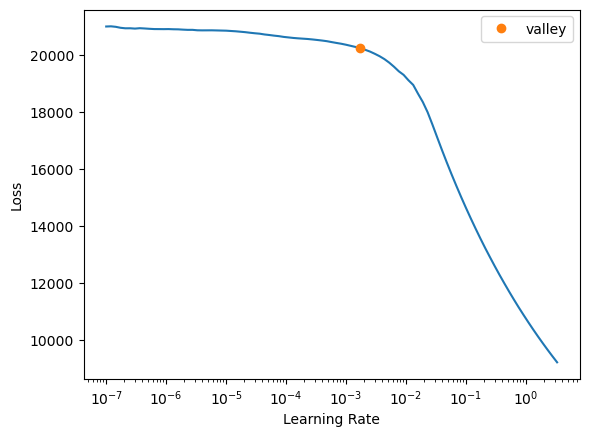

In [ ]:
dls = tabular.dataloaders(1024)
y = tabular.train.y
learn = tabular_learner(dls, y_range=(np.floor(y.min()), np.ceil(y.max())), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,1140.714600,425.838104,00:11
1,89.706413,84.319626,00:11
2,74.052803,75.043991,00:11
3,70.789337,73.257805,00:11
4,70.935936,74.320374,00:10
5,66.664528,75.790878,00:11
6,62.682407,76.475174,00:11
7,53.296520,79.220825,00:11
8,46.919090,83.329681,00:11
9,41.687027,85.291588,00:11


We see that something close to 4 or 5 epochs is better

In [ ]:
learn = tabular_learner(dls, y_range=(np.floor(y.min()), np.ceil(y.max())), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
learn.fit_one_cycle(4, 1e-2)
preds, targs = learn.get_preds()
r_mse (preds,targs)

epoch,train_loss,valid_loss,time
0,330.322357,79.072960,00:11
1,74.985626,77.427147,00:10
2,65.647713,74.557907,00:11
3,52.257278,76.169220,00:11


8.727498

Let's see with a lower learning rate:

In [ ]:
learn = tabular_learner(dls, y_range=(np.floor(y.min()), np.ceil(y.max())), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,time


## Ensemble of RF and NN

In [ ]:
preds, targs = learn.get_preds()
r_mse (preds,targs)

In [ ]:
rf_preds = rf_model.predict(valid_X_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2
r_mse(ens_preds,valid_y)

## End